<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/main/TLDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
!pip install datasets
!pip install rouge_score
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=79df080f2e1c633d6601e1300e61ef822a163f4f9244b205fd128a679c071a8f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [28]:
# Libraries
import os
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# Transformers
from datasets import Dataset, DatasetDict, load_metric
from transformers import TFBartForConditionalGeneration, BartTokenizer, pipeline
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamWeightDecay
from transformers.keras_callbacks import KerasMetricCallback
from transformers import PushToHubCallback

# NLTK
import nltk
nltk.download('punkt')

# AST
import ast

# Metrics
metric = load_metric('rouge')

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


'/content'

In [2]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


### Load and clean raw data

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [30]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [31]:
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/"

documents = os.listdir(BASE_PATH)

In [32]:
# AUXILIAR FUNCTIONS

# Define a function to safely convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell

# Join all the sentences of source and target
def clean_data(data, column):
  data[column] = data[column].apply(lambda x : ' '.join(x))
  return data


def metric_fn(eval_predictions):
  predictions, labels = eval_predictions
  decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  for label in labels:
      label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # Rouge expects a newline after each sentence
  decoded_predictions = [
      "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
  ]
  decoded_labels = [
      "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
  ]
  result = metric.compute(
      predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
  )
  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  # Add mean generated length
  prediction_lens = [
      np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
  ]
  result["gen_len"] = np.mean(prediction_lens)

  return result

In [85]:
data = pd.read_csv(BASE_PATH+'Data/Dev/Results/Extractive/extractive_summaries.csv')

data['source'] = data['source'].apply(convert_to_list)
data = clean_data(data, 'source')

data.sample(5)

,source,paper_id,target,title,number_words_target,extractive_summary
794,We propose a distributed architecture for deep...,H1Dy---0Z,A distributed architecture for deep reinforcem...,Distributed Prioritized Experience Replay,114,In this paper we describe an approach to scali...
1141,We explore ways of incorporating bilingual dic...,B1ecYsqSuN,We use bilingual dictionaries for data augment...,INCORPORATING BILINGUAL DICTIONARIES FOR LOW R...,37,A proven way to mitigate this issue has been b...
406,It has been shown that using geometric spaces ...,S1g6xeSKDS,Variational Autoencoders with latent spaces mo...,Mixed-curvature Variational Autoencoders,50,Generative models are a growing area of unsupe...
1144,Deep convolutional neural network (DCNN) based...,Hy-lXyDWG,The paper is about a new energy-efficient meth...,Incremental Learning in Deep Convolutional Neu...,66,One of the major challenges for convolutional ...
634,We propose an approach to training machine lea...,B1gdkxHFDH,Algorithm for training individually fair class...,Training individually fair ML models with sens...,32,"In this paper, we consider an adversarial appr..."


In [65]:
################
data = data[:100]
data.shape

(100, 6)

In [86]:
# Count number of words of source and target
def count_words(column):
  return data[column].apply(lambda x : len(x.split()))

data['number_words_target'] = count_words('target')
data['number_words_source'] = count_words('source')
data['number_words_extractive'] = count_words('extractive_summary')

In [87]:
print(data['number_words_target'].describe())
print(data['number_words_source'].describe())
print(data['number_words_extractive'].describe())

count    1312.000000
mean       58.935213
std        20.402388
min        30.000000
25%        41.000000
50%        58.000000
75%        73.000000
max       149.000000
Name: number_words_target, dtype: float64
count     1312.000000
mean      5177.437500
std       2107.094236
min        126.000000
25%       4069.750000
50%       5001.500000
75%       6187.750000
max      24589.000000
Name: number_words_source, dtype: float64
count    1312.000000
mean      621.176067
std       143.951058
min       126.000000
25%       534.000000
50%       611.000000
75%       693.000000
max      1199.000000
Name: number_words_extractive, dtype: float64


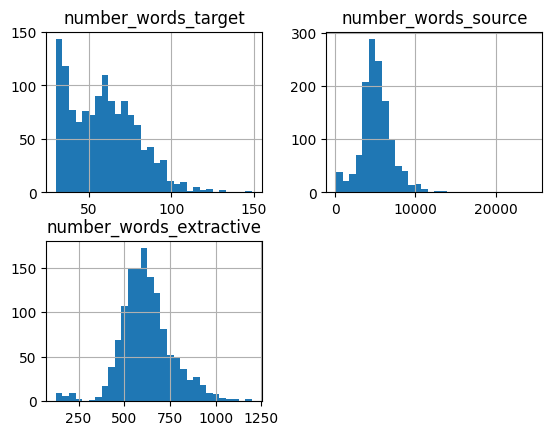

In [88]:
# Histogramas
data.hist(bins=30)
plt.show()

### BART



In [89]:
# Split data in different sets
data_training, data_test = train_test_split(data,
                                      test_size=0.20,
                                      random_state=42)

data_train, data_val = train_test_split(data_training,
                                        test_size=0.20,
                                        random_state=42)

In [90]:
print(data_train.shape, data_val.shape, data_training.shape, data_test.shape)

(839, 8) (210, 8) (1049, 8) (263, 8)


In [91]:
# Convert all data to HF DatasetDict
tf_data_train = Dataset.from_pandas(data_train)
tf_data_test = Dataset.from_pandas(data_test)
tf_data_val = Dataset.from_pandas(data_val)

raw_data = DatasetDict({'train': tf_data_train,
                           'validation': tf_data_val,
                           'test': tf_data_test})

In [93]:
# Load BART Base-Model + Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

model.generation_config.max_new_tokens = 60
model.generation_config.length_penalty = 3
model.generation_config.do_sample = True
model.generation_config.temperature = 0.5

model.config.attention_dropout = 0.2

print(model.generation_config)

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "do_sample": true,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 3,
  "max_new_tokens": 60,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "temperature": 0.5
}



In [94]:
# Function in order to tokenize source and target
max_input_length = 1024

def tokenize_function(data):
  model_inputs = tokenizer(data['extractive_summary'], max_length=max_input_length, truncation=True, padding=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(data['target'], padding=True)

  # The target input_ids tokens are added to the model inputs
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [95]:
# Tokenize data
tokenized_data = raw_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/839 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/263 [00:00<?, ? examples/s]

In [96]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

In [97]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [98]:
train_dataset = model.prepare_tf_dataset(
    tokenized_data['train'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
    drop_remainder=False
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)

generation_dataset = model.prepare_tf_dataset(
    tokenized_data['validation'],
    batch_size=2*batch_size,
    shuffle=False,
    collate_fn=generation_data_collator
)

In [99]:
# Iterate through the dataset to inspect the batches
for batch in train_dataset.take(2):  # Take the first batch for inspection
    print(batch)

({'input_ids': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[    0, 42850,     6, ...,     1,     1,     1],
       [    0,  3972,    42, ...,   775,    36,     2],
       [    0, 43095,     6, ...,     1,     1,     1],
       ...,
       [    0, 40025,  3693, ...,     1,     1,     1],
       [    0, 30383, 26713, ...,     1,     1,     1],
       [    0,   250,  1353, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(8, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'decoder_input_ids': <tf.Tensor: shape=(8, 182), dtype=int64, numpy=
array([[    2,     0, 47967, ...,     1,     1,     1],
       [    2,     0,   170, ...,     1,     1,     1],
       [    2,     0, 26145, ...,     1,     1,     1],
       ...,
       [    2,     0,   170, ...,     1,     1,     1],
      

In [100]:
# Compile model
optimizer = AdamWeightDecay(
    learning_rate=learning_rate, weight_decay_rate=weight_decay
)

model.compile(optimizer=optimizer)

model.summary()

Model: "tf_bart_for_conditional_generation_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
 final_logits_bias (BiasLay  multiple                  50265     
 er)                                                             
                                                                 
Total params: 139470681 (532.04 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 50265 (196.35 KB)
_________________________________________________________________


In [101]:
BASE_PATH

'/content/drive/MyDrive/VIU/TFM/Desarrollo/'

In [102]:
checkpoint_path = BASE_PATH + '/Results/TLDR/BART/model_save/checkpoint'
os.makedirs(checkpoint_path, exist_ok=True)

In [103]:
BART_PATH = BASE_PATH + '/Results/TLDR/BART'

#tensorboard_callback = TensorBoard(log_dir=BART_PATH+'/BART_model_save/logs')

metric_callback = KerasMetricCallback(
    metric_fn,
    eval_dataset=generation_dataset,
    predict_with_generate=True
)

push_to_hub_callback = PushToHubCallback(
    output_dir="./model_save",
    tokenizer=tokenizer,
    hub_model_id="iguerrasevillano/BART-summ-v1",
    save_strategy='epoch',
    checkpoint=True
)


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path+"/weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)

callbacks = [metric_callback,
             push_to_hub_callback,
             stop_early,
             checkpoint_callback]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/model_save is already a clone of https://huggingface.co/iguerrasevillano/BART-summ-v1. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
resume = False
epochs = 10

if resume:
  # from tensorflow.keras.models import load_model

  # Load the saved weights
  model.load_weights(checkpoint_path+'/weights.h5')

  # Continue training with the loaded weights
  print('[INFO: fine-tuning model...]')
  H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

else:
  # Train
  print('[INFO: fine-tuning model...]')
  H = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=callbacks)

[INFO: fine-tuning model...]
Epoch 1/10


In [ ]:
def plot_graphics(H):

    # Create a figure with 1 row and 2 columns, and set the figure size
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot the training and validation loss for each epoch in the first subplot
    ax[0].plot(np.arange(0,len(H.history["loss"]) ), H.history["loss"], label="loss")
    ax[0].plot(np.arange(0,len(H.history["loss"])), H.history["val_loss"], label="val_loss")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge1"], label="rouge1")
    ax[1].plot(np.arange(0,len(H.history["loss"])), H.history["rouge2"], label="rouge2")
    plt.legend()

plot_graphics(H)

In [154]:
print('[INFO]: generating tests summaries...')
generated_ids = model.generate(tokenized_data['test']['input_ids'], num_return_sequences=2)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[1]

[INFO]: generating tests summaries...


'We propose a deep neural network (BR-Net) to predict labels from images, which is unbiased to the underlying bias in the data.'

In [159]:
generated_ids

<tf.Tensor: shape=(40, 72), dtype=int32, numpy=
array([[  2,   0, 170, ...,   1,   1,   1],
       [  2,   0, 170, ...,   1,   1,   1],
       [  2,   0, 170, ...,   1,   1,   1],
       ...,
       [  2,   0, 170, ...,   1,   1,   1],
       [  2,   0, 170, ...,   1,   1,   1],
       [  2,   0, 170, ...,   1,   1,   1]], dtype=int32)>

In [137]:
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

'We propose a deep neural network (BR-Net) to predict labels from images, which is unbiased to the underlying bias in the dataset.'

In [138]:
# Fine-tuned model Test
predicted_labels = np.array(generated_ids)
reference_labels = np.array(tokenized_data['test']['labels'])

metric_fn((predicted_labels, reference_labels))

{'rouge1': 32.34354232483341,
 'rouge2': 10.579777008718464,
 'rougeL': 24.41126671125156,
 'rougeLsum': 24.664965912940556,
 'gen_len': 41.25}

In [141]:
model.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 3,
  "max_new_tokens": 80,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

In [144]:
# Pretrained model Test (check how results have improved)
pretrained_model = TFAutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

pretrained_model.generation_config.max_new_tokens = model.generation_config.max_new_tokens
pretrained_model.generation_config.length_penalty = model.generation_config.length_penalty


pretrained_generated_ids = pretrained_model.generate(tokenized_data['test']['input_ids'])
pretrained_predicted_labels = np.array(pretrained_generated_ids)

metric_fn((pretrained_predicted_labels, reference_labels))

All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.
/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': 15.611755054050452,
 'rouge2': 3.519979513900487,
 'rougeL': 12.288732891223875,
 'rougeLsum': 12.41976755747476,
 'gen_len': 20.0}

In [151]:
i = 6
print('ORIGINAL:' + tokenized_data['test']['target'][i])
print('FINE TUNED MODEL:' + tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[i])
print('PRETRAINED MODEL:' + tokenizer.batch_decode(pretrained_generated_ids, skip_special_tokens=True)[i])

ORIGINAL:OE teaches anomaly detectors to learn heuristics for detecting unseen anomalies; experiments are in classification, density estimation, and calibration in NLP and vision settings; we do not tune on test distribution samples, unlike previous work
FINE TUNED MODEL:Outlier Exposure improves the calibration of neural network classifiers in the realistic setting where a fraction of the data is OOD. We show that Outlier Exposure can improve calibration performance in this realistic setting.
PRETRAINED MODEL:However, when there is a distribution mismatch, deep neural network classifiers tend to give


In [153]:
data['extractive_summary'][10]

'In particular, (Santurkar et al., 2018) recently studied the mode collapsing problem and further classified this into the missing mode problem i.e., the generated samples miss some modes in the true data, and the boundary distortion problem i.e., the generated samples can only partly recover some modes in the true data. To handle sequential data in the context of domain adaptation of software vulnerability detection, the work of proposed an architecture referred to as the Code Domain Adaptation Network (CDAN). A fully connected layer is then employed to connect the output layer of the Bidirectional RNN with the joint feature layer while bridging the gap between the source and target domains. In particular, (Santurkar et al., 2018) has recently studied the mode collapsing problem of GANs and discovered that they are also subject to i) the missing mode problem (i.e., in the joint space, either the target data misses some modes in the source data or vice versa) and ii) the boundary disto